In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pickle
# 导入向量化后的数据集
np_vectorized_doc2vec = pickle.load(open('vectorized_generated_corpus_doc2vec.pkl', 'rb'))

In [3]:
np_vectorized_doc2vec[:10]

array([[ 2.89205345e-03, -8.08892597e-04,  8.15546606e-03,
         2.75301165e-03, -2.06303652e-04,  3.62663390e-03,
         2.09601549e-03, -6.57518348e-03,  7.35852215e-03,
         8.96254554e-03,  2.76255235e-03,  4.64767311e-03,
        -1.61031168e-03, -7.87248835e-03, -6.28709036e-04,
         2.22694036e-03, -7.67329475e-03,  2.63439328e-03,
         1.68644066e-04,  7.68062519e-03,  3.52390180e-03,
        -1.26587565e-03, -1.60900466e-02,  7.23800482e-03,
        -2.49217410e-04, -2.50085257e-03,  6.15369948e-03,
        -5.93211222e-03,  1.08864624e-02,  1.31676544e-03,
        -3.44674848e-03, -1.31698232e-03,  2.49618106e-03,
         1.84177384e-02,  2.72081629e-03, -4.40125586e-03,
         2.39745932e-04, -3.93963791e-03,  1.15586082e-02,
         3.69167840e-03,  4.17817011e-03,  5.27888024e-03,
         4.76419041e-03,  4.90524527e-03, -4.24468704e-03,
         6.18346455e-03,  6.33573974e-04,  5.80844330e-03,
         3.62944702e-04, -4.45647398e-04, -3.53119336e-0

In [4]:
np_vectorized_doc2vec = np_vectorized_doc2vec * 100

In [5]:
np_vectorized_doc2vec[:10]

array([[ 2.89205343e-01, -8.08892623e-02,  8.15546632e-01,
         2.75301158e-01, -2.06303652e-02,  3.62663388e-01,
         2.09601551e-01, -6.57518327e-01,  7.35852242e-01,
         8.96254539e-01,  2.76255250e-01,  4.64767307e-01,
        -1.61031172e-01, -7.87248850e-01, -6.28709048e-02,
         2.22694039e-01, -7.67329454e-01,  2.63439327e-01,
         1.68644059e-02,  7.68062532e-01,  3.52390170e-01,
        -1.26587570e-01, -1.60900462e+00,  7.23800480e-01,
        -2.49217413e-02, -2.50085264e-01,  6.15369976e-01,
        -5.93211234e-01,  1.08864629e+00,  1.31676540e-01,
        -3.44674855e-01, -1.31698236e-01,  2.49618113e-01,
         1.84177387e+00,  2.72081643e-01, -4.40125585e-01,
         2.39745937e-02, -3.93963784e-01,  1.15586078e+00,
         3.69167835e-01,  4.17816997e-01,  5.27888000e-01,
         4.76419032e-01,  4.90524530e-01, -4.24468696e-01,
         6.18346453e-01,  6.33573979e-02,  5.80844343e-01,
         3.62944715e-02, -4.45647389e-02, -3.53119344e-0

In [6]:
np_vectorized_doc2vec.shape

(1200, 100)

In [7]:
np_vectorized_doc2vec.dtype

dtype('float32')

In [8]:
# DataLoader is used to load the dataset
# for training
loader = torch.utils.data.DataLoader(dataset = np_vectorized_doc2vec,
                                      batch_size = 32,
                                      shuffle = True)

In [9]:
# Creating a PyTorch class
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 100 ==> 2
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(100, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 25),
            torch.nn.ReLU(),
            torch.nn.Linear(25, 12),
            torch.nn.ReLU(),
            torch.nn.Linear(12, 6),
            torch.nn.ReLU(),
            torch.nn.Linear(6, 3),
            torch.nn.ReLU(),
            torch.nn.Linear(3, 2)
        )
        
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 2 ==> 100
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(2, 3),
            torch.nn.ReLU(),
            torch.nn.Linear(3, 6),
            torch.nn.ReLU(),
            torch.nn.Linear(6, 12),
            torch.nn.ReLU(),
            torch.nn.Linear(12, 25),
            torch.nn.ReLU(),
            torch.nn.Linear(25, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 100),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return (encoded, decoded) # encoded is the result of dimensionality reduction

In [25]:
# Model Initialization
model = AE()
model.cuda()  # move the model to GPU

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.01
optimizer = torch.optim.Adam(model.parameters(),
							lr = 0.001,
							weight_decay = 0.00000001)

In [26]:
epochs = 100
iters = 0
outputs = []
losses = []

for epoch in range(1, epochs + 1):
    print('Epoch:', epoch)
    for essay in loader:
        iters += 1

        essay = essay.cuda()  # move data to GPU

        # Output of Autoencoder
        _, reconstructed = model(essay)

        # Calculating the loss function
        loss = loss_function(reconstructed, essay)

        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Storing the losses in a list for plotting
        losses.append(loss.item())
        if iters % 100 == 0:
            print(f"Iteration: {iters}, loss is: {loss.item()}")

    outputs.append((epoch, essay, reconstructed))

Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 100, loss is: 1.2481440305709839
Epoch: 4
Epoch: 5
Epoch: 6
Iteration: 200, loss is: 1.322247862815857
Epoch: 7
Epoch: 8
Iteration: 300, loss is: 1.3557422161102295
Epoch: 9
Epoch: 10
Epoch: 11
Iteration: 400, loss is: 1.3661166429519653
Epoch: 12
Epoch: 13
Epoch: 14
Iteration: 500, loss is: 0.926214873790741
Epoch: 15
Epoch: 16
Iteration: 600, loss is: 1.151582956314087
Epoch: 17
Epoch: 18
Epoch: 19
Iteration: 700, loss is: 1.0335992574691772
Epoch: 20
Epoch: 21
Epoch: 22
Iteration: 800, loss is: 1.104179859161377
Epoch: 23
Epoch: 24
Iteration: 900, loss is: 1.1319388151168823
Epoch: 25
Epoch: 26
Epoch: 27
Iteration: 1000, loss is: 1.0852938890457153
Epoch: 28
Epoch: 29
Iteration: 1100, loss is: 0.9587375521659851
Epoch: 30
Epoch: 31
Epoch: 32
Iteration: 1200, loss is: 0.8972103595733643
Epoch: 33
Epoch: 34
Epoch: 35
Iteration: 1300, loss is: 1.4820460081100464
Epoch: 36
Epoch: 37
Iteration: 1400, loss is: 1.0926274061203003
Epoch: 38
Epoch: 39
Ep

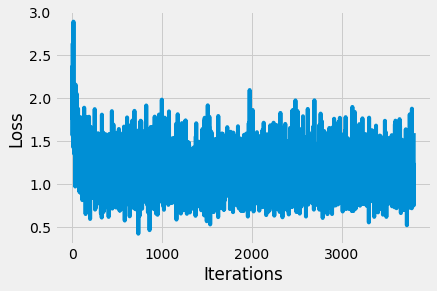

In [27]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the last 100 values
plt.plot(losses)

In [28]:
outputs[-1]

(100, tensor([[-6.0703e-03, -6.9137e-01,  3.1601e+00,  ..., -6.6603e-01,
           1.1308e+00, -2.8217e-01],
         [-6.4268e-01, -2.6877e-01,  6.5629e-01,  ..., -1.0457e-01,
          -3.8172e-02, -1.5890e-01],
         [ 7.7273e-02, -6.7102e-01,  1.0365e+00,  ..., -8.9065e-01,
           6.7124e-01, -6.7336e-01],
         ...,
         [ 4.3900e-01, -7.8235e-02,  3.8324e-01,  ..., -4.1070e-01,
           5.6946e-01, -5.3210e-01],
         [-5.9099e-01,  3.1254e-01,  1.9878e-01,  ..., -1.1120e+00,
           7.3588e-01, -1.7648e+00],
         [-3.2425e-01, -2.9164e-03,  4.5363e-01,  ..., -7.5261e-01,
           4.9603e-01, -3.0125e-01]], device='cuda:0'), tensor([[3.0431e-01, 3.2909e-08, 1.0000e+00,  ..., 1.2212e-08, 9.6091e-01,
          5.2183e-02],
         [3.0017e-01, 4.4959e-06, 9.9993e-01,  ..., 3.9846e-06, 4.9102e-01,
          2.9704e-01],
         [1.8354e-05, 2.4166e-35, 1.0000e+00,  ..., 4.3961e-39, 1.0000e+00,
          6.5334e-13],
         ...,
         [2.6569e-01, 

In [29]:
# Dimensionality Reduction by the trained AE model

decomposition_data = []
for essay in np_vectorized_doc2vec:
    essay = torch.from_numpy(essay).cuda()
    encoded, decoded = model(essay)
    decomposition_data.append(encoded.cpu().data.numpy())

decomposition_data = np.array(decomposition_data)

In [30]:
decomposition_data

array([[  1.6190089,   8.73131  ],
       [ 44.47672  , -18.165787 ],
       [ 14.9956665,  -4.7146974],
       ...,
       [ 20.601044 ,  -5.629527 ],
       [ 19.852217 ,  -6.7869306],
       [ 82.88141  , -39.571327 ]], dtype=float32)

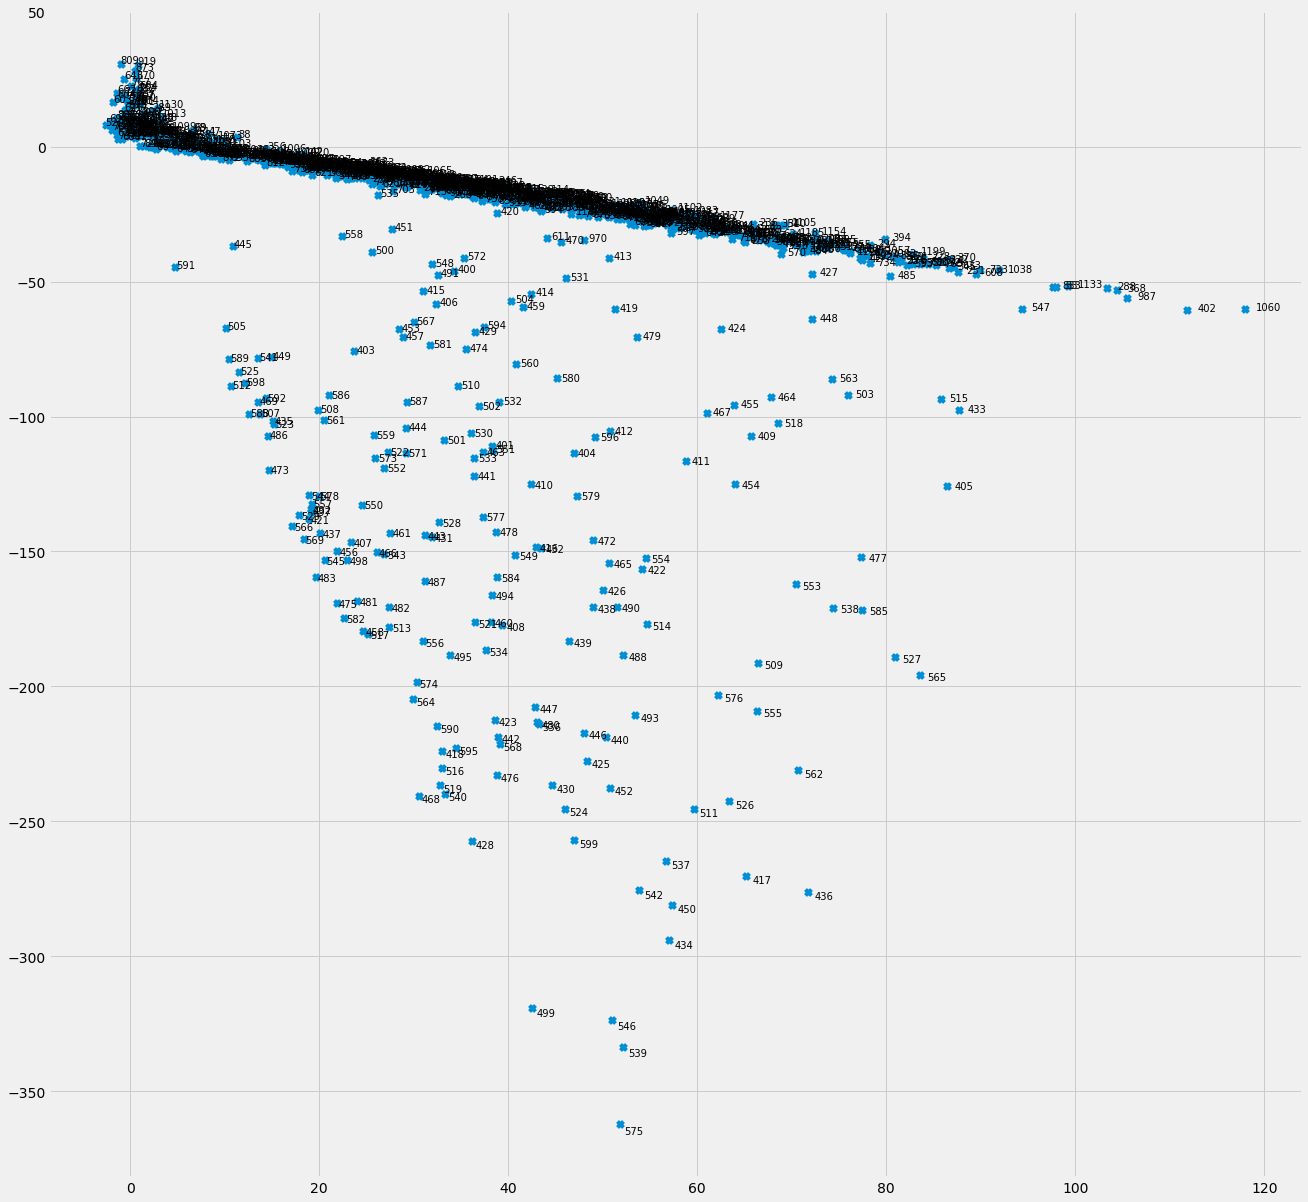

In [31]:
fig = plt.figure(figsize=(20, 20))
ax = plt.axes()
plt.scatter(decomposition_data[:, 0], decomposition_data[:, 1], marker='x')
for i in range(len(decomposition_data)):
    plt.text(decomposition_data[:, 0][i] * 1.01, decomposition_data[:, 1][i] * 1.01, i, fontsize=10)
plt.show()

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [66]:
# 保存模型参数
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/model/SixTypes-AutoEncoder-K-Means-Word2vec.pth')

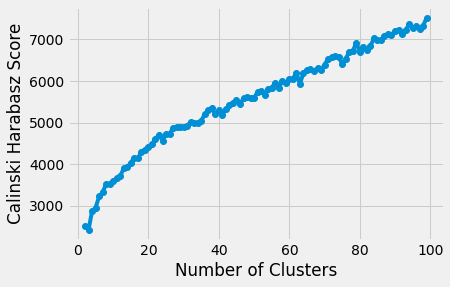

In [32]:
# K-means 算法聚类并利用 Calinski Harabasz Score 评估效果
from sklearn.cluster import KMeans
from sklearn import metrics
calinski_harabasz_score_list = []
for n_cluster in range(2, 100):
    y_pred = KMeans(n_clusters=n_cluster, init='k-means++', random_state=9).fit_predict(decomposition_data)
    current_score = metrics.calinski_harabasz_score(decomposition_data, y_pred)
    calinski_harabasz_score_list.append(current_score)

plt.plot(range(2,100), calinski_harabasz_score_list, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski Harabasz Score')
plt.show()

In [33]:
calinski_harabasz_score_list.index(max(calinski_harabasz_score_list))

97

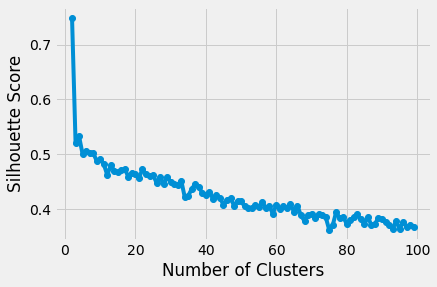

In [34]:
# K-means 算法聚类并利用 Silhouette Score（轮廓系数）评估效果
silhouette_score_list = []
for n_cluster in range(2, 100):
    km = KMeans(n_clusters=n_cluster, random_state=9)
    y_pred = km.fit_predict(decomposition_data)
    current_score = metrics.silhouette_score(decomposition_data, km.labels_ , metric='euclidean')
    silhouette_score_list.append(current_score)

plt.plot(range(2,100), silhouette_score_list, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [35]:
silhouette_score_list.index(max(silhouette_score_list))

0

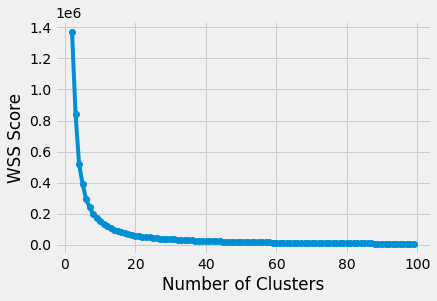

In [36]:
# K-means 算法聚类并利用 WSS（Within-cluster Sum of Squares）评估效果
WSS_score_list = []
for n_cluster in range(2, 100):
    km = KMeans(n_clusters=n_cluster, random_state=9)
    y_pred = km.fit_predict(decomposition_data)
    current_score = km.inertia_
    WSS_score_list.append(current_score)

plt.plot(range(2,100), WSS_score_list, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WSS Score')
plt.show()

In [37]:
# 选用 k 值做 K-means 算法聚类
y_pred = KMeans(n_clusters=6, init='k-means++', random_state=9).fit_predict(decomposition_data)

In [38]:
print(y_pred[:10])

[2 0 2 2 5 0 0 0 2 5]


In [39]:
import numpy as np
# 用 dict 统计出所有类别的坐标
y_pred_dict = {}
for i in range(len(decomposition_data)):
    if y_pred[i] not in y_pred_dict:
        y_pred_dict[y_pred[i]] = decomposition_data[i].reshape(1, 2)
    else:
        y_pred_dict[y_pred[i]] = np.vstack((y_pred_dict[y_pred[i]], decomposition_data[i]))

In [40]:
for key, value in y_pred_dict.items():
    print(key, value[:, 0].mean())

2 8.297479
0 33.67313
5 64.12558
4 36.39676
1 37.290638
3 47.906265


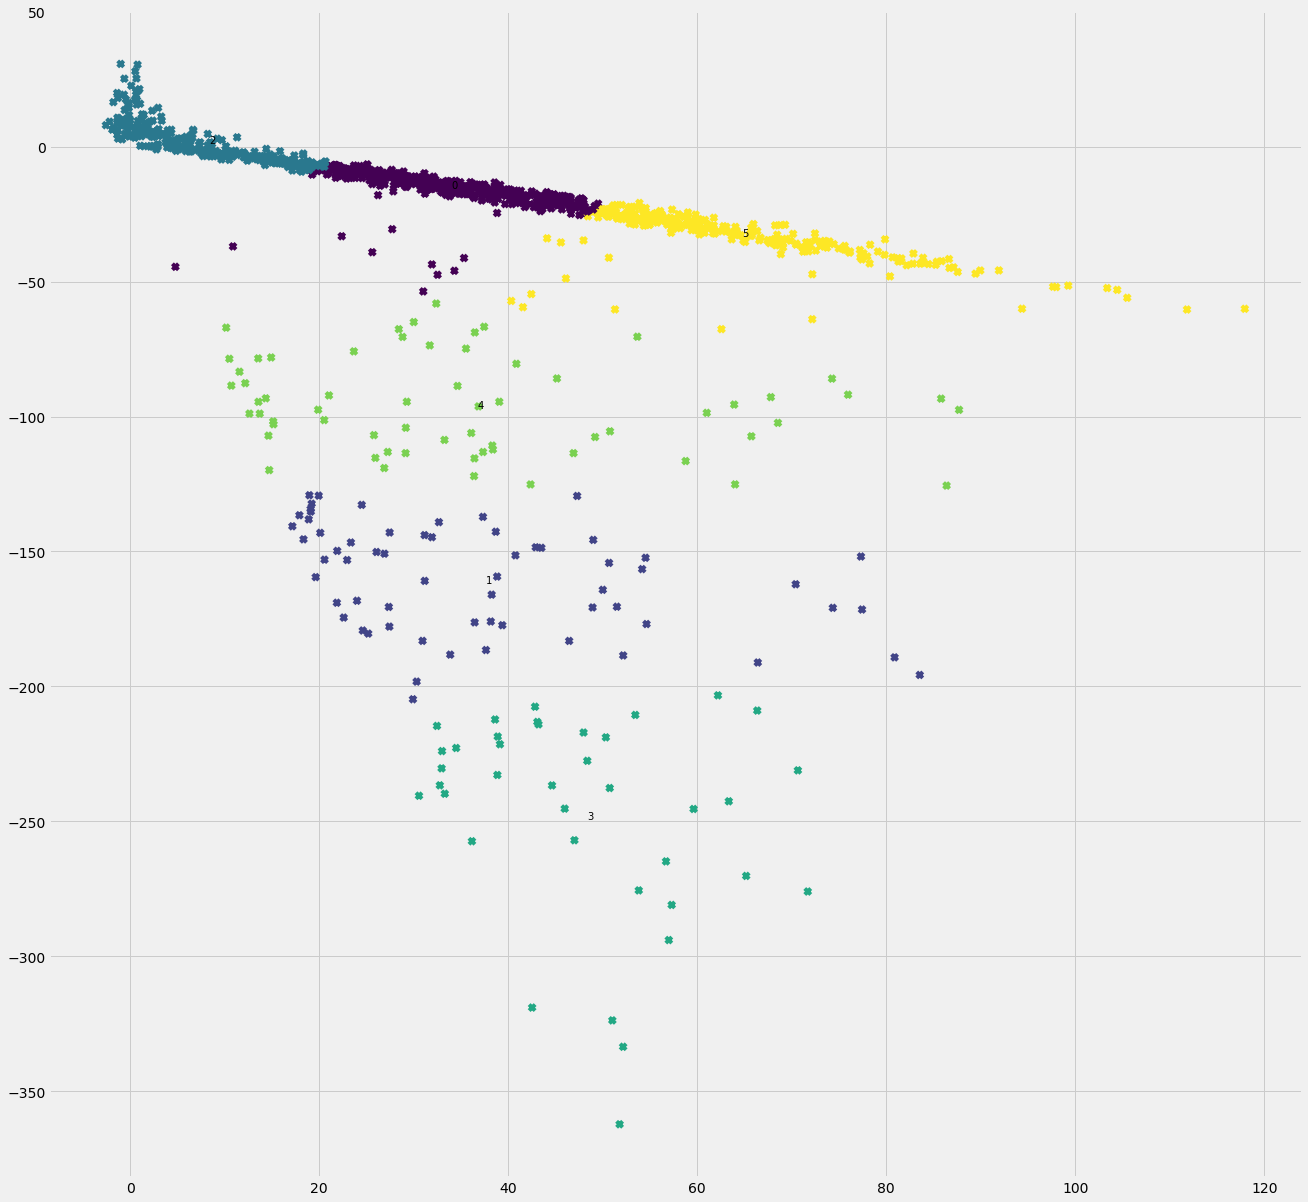

In [41]:
fig = plt.figure(figsize=(20, 20))
ax = plt.axes()
plt.scatter(decomposition_data[:, 0], decomposition_data[:, 1], c=y_pred, marker='x')
for key, value in y_pred_dict.items():
    plt.text(value[:, 0].mean() * 1.01, value[:, 1].mean() * 1.01, key, fontsize=10)
plt.show()

In [42]:
# 利用 Calinski Harabasz Score 评估当前 K-Means 聚类效果（利用 Word2vec 表征）
metrics.calinski_harabasz_score(decomposition_data, y_pred)

3224.178063011421

In [43]:
# 利用 Silhouette Score（轮廓系数）评估当前 K-Means 聚类效果（利用 Word2vec 表征）
km = KMeans(n_clusters=6, random_state=9)
y_pred = km.fit_predict(decomposition_data)
metrics.silhouette_score(decomposition_data, km.labels_, metric='euclidean')

0.5067808

In [44]:
# 读入正确标签（Labels）
labels = []
# 读入数据集
with open('sixTypes-GeneratedLabels.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
        labels.append(line.strip('\n'))

In [45]:
labels[:10]

['CP', 'CP', 'CP', 'CP', 'CP', 'CP', 'CP', 'CP', 'CP', 'CP']

In [46]:
# 利用 Homogeneity 评估当前 K-Means 聚类效果（利用 Word2vec 表征）
metrics.homogeneity_score(labels, y_pred)

0.19098122719425006

In [47]:
# 利用 Completeness 评估当前 K-Means 聚类效果（利用 Word2vec 表征）
metrics.completeness_score(labels, y_pred)

0.23270376214921454

In [48]:
# 利用 V-measure 评估当前 K-Means 聚类效果（利用 Word2vec 表征）
metrics.v_measure_score(labels, y_pred)

0.20978817369405772

In [49]:
# 利用 Adjusted Rand Index（调整兰德系数）评估当前 K-Means 聚类效果（利用 Word2vec 表征）
metrics.adjusted_rand_score(labels, y_pred)

0.07018393646296477

In [50]:
# 利用 Adjusted Mutual Information Score（调整互信息）评估当前 K-Means 聚类效果（利用 Word2vec 表征）
metrics.adjusted_mutual_info_score(labels, y_pred)

0.20461998209065746

In [51]:
# 利用 Fowlkes-Mallows scores 评估当前 K-Means 聚类效果（利用 Word2vec 表征）
metrics.fowlkes_mallows_score(labels, y_pred)

0.26846695185368447